# CNN Training

Target of this code is to train a CNN network to classify images of a digital readout to the digits 0 to 9. Additionally a category "NaN" is introduced, to mark images that are not amibiguous.

### Preparing the training
* First all libraries are loaded
    * It is assumed, that they are installed during the Python setup
* matplotlib is set to print the output inline in the jupyter notebook

In [1]:
########### Basic Parameters for Running: ################################
    
TFliteNamingAndVersion = "dig0870"     # Used for tflite Filename
Training_Percentage = 0.2              # 0.0 = Use all Images for Training
Epoch_Anz = 400

##########################################################################


import tensorflow as tf
import matplotlib.pyplot as plt
import glob
import numpy as np
from sklearn.utils import shuffle
from tensorflow.python import keras
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Dense, InputLayer, Conv2D, MaxPool2D, Flatten, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import History 
from tensorflow.keras.utils import to_categorical
from PIL import Image 

loss_ges = np.array([])
val_loss_ges = np.array([])

%matplotlib inline
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

### Load training data
* The data is expected in the "Input_dir"
* Inside subdirectories are expected from -1, 0, 1, ... 9 in which the pictures are sorted according to their values (=category)
* Picture size must be 20x32 with 3 color channels (RGB)
* The filename can be arbitrary

* The images are stored in the x_data[]
* The expected category for each image in the corresponding y_data[]

* The last step is a shuffle (from sklearn.utils) and split the data into training and validation data

In [2]:
Input_dir='ziffer_sortiert_resize'

files = glob.glob(Input_dir + '/*.*')
x_data = []
y_data = []

subdir = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "NaN"]

for aktsubdir in subdir:
    files = glob.glob(Input_dir + '/' + aktsubdir + '/*.jpg')
    if aktsubdir == "NaN":
        category = 10                # NaN does not work --> convert to 10
    else:
        category = aktsubdir
    for aktfile in files:
        test_image = Image.open(aktfile)
        test_image = np.array(test_image, dtype="float32")
        x_data.append(test_image)
        y_data.append(np.array([category]))

x_data = np.array(x_data)
y_data = np.array(y_data)
y_data = to_categorical(y_data, 11)
print(x_data.shape)
print(y_data.shape)

x_data, y_data = shuffle(x_data, y_data)

if (Training_Percentage > 0):
    X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=Training_Percentage)
else:
    X_train = x_data
    y_train = y_data

(1132, 32, 20, 3)
(1132, 11)


### Define the model

The layout of the network ist a typcial CNN network with alternating **Conv2D** and **MaxPool2D** layers. Finished after **flattening** with additional **Dense** layer.

#### Important
* Shape of the input layer: (32, 20, 3)
* Number of output layers: 11
* As loss function "categorical_crossentropy" is choosen, as it is a categories task

In [3]:
model = Sequential()
model.add(BatchNormalization(input_shape=(32,20,3)))
model.add(Conv2D(32, (3, 3), padding='same', activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(512,activation="relu"))
model.add(Dense(11, activation = "softmax"))
model.summary()

model.compile(loss=keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95), metrics = ["accuracy"])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 32, 20, 3)         12        
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 20, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 10, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 10, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 5, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 2, 64)          0

# Training
The input pictures are randomly scattered for brightness, pixel shift variations and rotation angle. This is implemented with a ImageDataGenerator.


In [4]:
Batch_Size = 4
Shift_Range = 1
Brightness_Range = 0.3
Rotation_Angle = 10
ZoomRange = 0.4

datagen = ImageDataGenerator(width_shift_range=[-Shift_Range,Shift_Range], 
                             height_shift_range=[-Shift_Range,Shift_Range],
                             brightness_range=[1-Brightness_Range,1+Brightness_Range],
                             zoom_range=[1-ZoomRange, 1+ZoomRange],
                             rotation_range=Rotation_Angle)

if (Training_Percentage > 0):
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    validation_iterator = datagen.flow(X_test, y_test, batch_size=Batch_Size)
    history = model.fit(train_iterator, validation_data = validation_iterator, epochs = Epoch_Anz)
else:
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    history = model.fit(train_iterator, epochs = Epoch_Anz)



Epoch 1/400
283/283 [==============================] - 4s 13ms/step - loss: 2.1464 - accuracy: 0.3405 - val_loss: 1.3438 - val_accuracy: 0.5727
Epoch 2/400
283/283 [==============================] - 2s 9ms/step - loss: 1.2901 - accuracy: 0.6038 - val_loss: 0.9185 - val_accuracy: 0.7048
Epoch 3/400
283/283 [==============================] - 3s 9ms/step - loss: 0.9310 - accuracy: 0.7012 - val_loss: 0.5728 - val_accuracy: 0.8062
Epoch 4/400
283/283 [==============================] - 3s 9ms/step - loss: 0.6417 - accuracy: 0.8138 - val_loss: 0.5434 - val_accuracy: 0.8414
Epoch 5/400
283/283 [==============================] - 2s 9ms/step - loss: 0.5499 - accuracy: 0.8314 - val_loss: 0.4244 - val_accuracy: 0.8590
Epoch 6/400
283/283 [==============================] - 2s 8ms/step - loss: 0.4624 - accuracy: 0.8527 - val_loss: 0.4475 - val_accuracy: 0.8634
Epoch 7/400
283/283 [==============================] - 3s 9ms/step - loss: 0.5199 - accuracy: 0.8557 - val_loss: 0.3265 - val_accuracy: 0.907

283/283 [==============================] - 4s 15ms/step - loss: 0.0705 - accuracy: 0.9757 - val_loss: 0.0510 - val_accuracy: 0.9780
Epoch 58/400
283/283 [==============================] - 4s 15ms/step - loss: 0.0866 - accuracy: 0.9780 - val_loss: 0.0523 - val_accuracy: 0.9868
Epoch 59/400
283/283 [==============================] - 4s 15ms/step - loss: 0.0893 - accuracy: 0.9750 - val_loss: 0.0206 - val_accuracy: 0.9956
Epoch 60/400
283/283 [==============================] - 4s 15ms/step - loss: 0.0489 - accuracy: 0.9850 - val_loss: 0.0692 - val_accuracy: 0.9692
Epoch 61/400
283/283 [==============================] - 4s 14ms/step - loss: 0.0765 - accuracy: 0.9805 - val_loss: 0.0637 - val_accuracy: 0.9780
Epoch 62/400
283/283 [==============================] - 4s 14ms/step - loss: 0.0640 - accuracy: 0.9840 - val_loss: 0.0183 - val_accuracy: 0.9956
Epoch 63/400
283/283 [==============================] - 4s 15ms/step - loss: 0.0959 - accuracy: 0.9752 - val_loss: 0.0633 - val_accuracy: 0.978

283/283 [==============================] - 4s 14ms/step - loss: 0.0692 - accuracy: 0.9856 - val_loss: 0.0529 - val_accuracy: 0.9824
Epoch 114/400
283/283 [==============================] - 4s 14ms/step - loss: 0.0963 - accuracy: 0.9855 - val_loss: 0.0960 - val_accuracy: 0.9780
Epoch 115/400
283/283 [==============================] - 4s 14ms/step - loss: 0.0584 - accuracy: 0.9807 - val_loss: 0.1345 - val_accuracy: 0.9868
Epoch 116/400
283/283 [==============================] - 4s 14ms/step - loss: 0.0500 - accuracy: 0.9875 - val_loss: 0.1404 - val_accuracy: 0.9692
Epoch 117/400
283/283 [==============================] - 4s 14ms/step - loss: 0.1343 - accuracy: 0.9787 - val_loss: 0.0212 - val_accuracy: 0.9912
Epoch 118/400
283/283 [==============================] - 4s 14ms/step - loss: 0.1279 - accuracy: 0.9827 - val_loss: 0.0500 - val_accuracy: 0.9780
Epoch 119/400
283/283 [==============================] - 4s 15ms/step - loss: 0.0498 - accuracy: 0.9796 - val_loss: 0.0252 - val_accuracy:

283/283 [==============================] - 4s 14ms/step - loss: 0.0234 - accuracy: 0.9918 - val_loss: 7.1269e-04 - val_accuracy: 1.0000
Epoch 170/400
283/283 [==============================] - 4s 13ms/step - loss: 0.0571 - accuracy: 0.9879 - val_loss: 0.0860 - val_accuracy: 0.9780
Epoch 171/400
283/283 [==============================] - 4s 13ms/step - loss: 0.0257 - accuracy: 0.9923 - val_loss: 0.0401 - val_accuracy: 0.9868
Epoch 172/400
283/283 [==============================] - 4s 14ms/step - loss: 0.0228 - accuracy: 0.9915 - val_loss: 0.0150 - val_accuracy: 0.9956
Epoch 173/400
283/283 [==============================] - 4s 14ms/step - loss: 0.0291 - accuracy: 0.9918 - val_loss: 0.0518 - val_accuracy: 0.9912
Epoch 174/400
283/283 [==============================] - 4s 13ms/step - loss: 0.0592 - accuracy: 0.9894 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 175/400
283/283 [==============================] - 4s 13ms/step - loss: 0.0209 - accuracy: 0.9937 - val_loss: 0.0315 - val_accur

283/283 [==============================] - 4s 13ms/step - loss: 0.0693 - accuracy: 0.9864 - val_loss: 0.0085 - val_accuracy: 0.9956
Epoch 226/400
283/283 [==============================] - 4s 14ms/step - loss: 0.0290 - accuracy: 0.9935 - val_loss: 0.0039 - val_accuracy: 1.0000
Epoch 227/400
283/283 [==============================] - 4s 13ms/step - loss: 0.0376 - accuracy: 0.9887 - val_loss: 0.0561 - val_accuracy: 0.9868
Epoch 228/400
283/283 [==============================] - 4s 13ms/step - loss: 0.0397 - accuracy: 0.9848 - val_loss: 0.0057 - val_accuracy: 1.0000
Epoch 229/400
283/283 [==============================] - 4s 13ms/step - loss: 0.0441 - accuracy: 0.9912 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 230/400
283/283 [==============================] - 4s 14ms/step - loss: 0.0337 - accuracy: 0.9889 - val_loss: 0.0306 - val_accuracy: 0.9912
Epoch 231/400
283/283 [==============================] - 4s 14ms/step - loss: 0.0180 - accuracy: 0.9974 - val_loss: 0.0090 - val_accuracy:

283/283 [==============================] - 3s 9ms/step - loss: 0.0298 - accuracy: 0.9938 - val_loss: 0.0158 - val_accuracy: 0.9956
Epoch 282/400
283/283 [==============================] - 3s 9ms/step - loss: 0.0089 - accuracy: 0.9970 - val_loss: 0.0362 - val_accuracy: 0.9780
Epoch 283/400
283/283 [==============================] - 3s 9ms/step - loss: 0.0175 - accuracy: 0.9953 - val_loss: 0.0305 - val_accuracy: 0.9956
Epoch 284/400
283/283 [==============================] - 3s 9ms/step - loss: 0.0108 - accuracy: 0.9970 - val_loss: 0.0913 - val_accuracy: 0.9912
Epoch 285/400
283/283 [==============================] - 3s 9ms/step - loss: 0.0353 - accuracy: 0.9889 - val_loss: 0.0041 - val_accuracy: 1.0000
Epoch 286/400
283/283 [==============================] - 3s 9ms/step - loss: 0.0326 - accuracy: 0.9878 - val_loss: 0.0040 - val_accuracy: 1.0000
Epoch 287/400
283/283 [==============================] - 3s 9ms/step - loss: 0.0399 - accuracy: 0.9899 - val_loss: 0.0026 - val_accuracy: 1.0000

283/283 [==============================] - 2s 8ms/step - loss: 0.0133 - accuracy: 0.9980 - val_loss: 0.0105 - val_accuracy: 0.9956
Epoch 338/400
283/283 [==============================] - 2s 9ms/step - loss: 0.0118 - accuracy: 0.9978 - val_loss: 0.0112 - val_accuracy: 0.9956
Epoch 339/400
283/283 [==============================] - 2s 8ms/step - loss: 0.0320 - accuracy: 0.9965 - val_loss: 2.4507e-04 - val_accuracy: 1.0000
Epoch 340/400
283/283 [==============================] - 2s 8ms/step - loss: 0.1042 - accuracy: 0.9863 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 341/400
283/283 [==============================] - 2s 7ms/step - loss: 0.0157 - accuracy: 0.9970 - val_loss: 3.1448e-04 - val_accuracy: 1.0000
Epoch 342/400
283/283 [==============================] - 2s 7ms/step - loss: 0.0407 - accuracy: 0.9961 - val_loss: 0.0198 - val_accuracy: 0.9912
Epoch 343/400
283/283 [==============================] - 2s 7ms/step - loss: 0.0030 - accuracy: 0.9988 - val_loss: 0.1036 - val_accuracy

283/283 [==============================] - 2s 6ms/step - loss: 0.0216 - accuracy: 0.9944 - val_loss: 0.0270 - val_accuracy: 0.9868
Epoch 394/400
283/283 [==============================] - 2s 6ms/step - loss: 0.0370 - accuracy: 0.9919 - val_loss: 7.1245e-04 - val_accuracy: 1.0000
Epoch 395/400
283/283 [==============================] - 2s 6ms/step - loss: 0.0219 - accuracy: 0.9987 - val_loss: 0.0164 - val_accuracy: 0.9956
Epoch 396/400
283/283 [==============================] - 2s 7ms/step - loss: 0.0207 - accuracy: 0.9932 - val_loss: 0.0235 - val_accuracy: 0.9956
Epoch 397/400
283/283 [==============================] - 2s 6ms/step - loss: 0.0294 - accuracy: 0.9901 - val_loss: 0.0151 - val_accuracy: 0.9956
Epoch 398/400
283/283 [==============================] - 2s 6ms/step - loss: 0.0235 - accuracy: 0.9957 - val_loss: 0.0523 - val_accuracy: 0.9912
Epoch 399/400
283/283 [==============================] - 2s 6ms/step - loss: 0.0448 - accuracy: 0.9887 - val_loss: 0.0546 - val_accuracy: 0.

### Learing result
 
* Visualization of the training and validation results

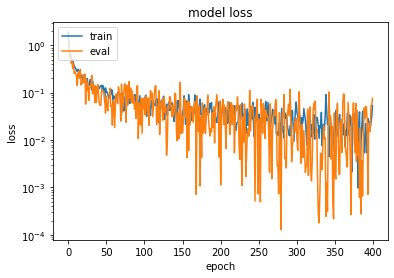

In [5]:
loss_ges = np.append(loss_ges, history.history['loss'])
plt.semilogy(history.history['loss'])

if (Training_Percentage > 0):
    val_loss_ges = np.append(val_loss_ges, history.history['val_loss'])
    plt.semilogy(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','eval'], loc='upper left')
plt.show()

### Check the model by hand

* The following code uses the trained model to check the deviation for each picture.
* x-axis walks through each pixel, y-axis shows the result

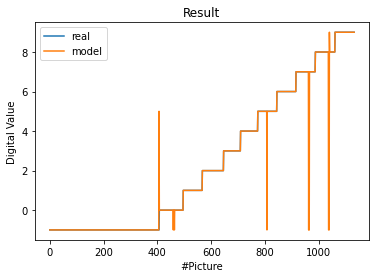

In [6]:
Input_dir='ziffer_sortiert_resize'
subdir = ["NaN", "0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
res = []

for aktsubdir in subdir:
    files = glob.glob(Input_dir + '/' + aktsubdir + '\*.jpg')
    if aktsubdir == "NaN":
        zw1 = -1
    else:
        zw1 = int(aktsubdir)
    for aktfile in files:
        test_image = Image.open(aktfile)
        test_image = np.array(test_image, dtype="float32")
        img = np.reshape(test_image,[1,32,20,3])
        classes = np.argmax(model.predict(img), axis=-1)
        classes = classes[0]
        if classes == 10: 
            classes = -1
        zw2 = classes
        zw3 = zw2 - zw1
        res.append(np.array([zw1, zw2, zw3]))

res = np.asarray(res)


plt.plot(res[:,0])
plt.plot(res[:,1])
plt.title('Result')
plt.ylabel('Digital Value')
plt.xlabel('#Picture')
plt.legend(['real','model'], loc='upper left')
plt.show()

### Save the model

* Save the model to the file with the "h5" file format

In [7]:
FileName = TFliteNamingAndVersion

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open(FileName + ".tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmpidkev02e\assets


1303008

In [8]:
FileName = TFliteNamingAndVersion + "q"

import tensorflow as tf

def representative_dataset():
    for _ in range(500):
      data = np.random.rand(1, 32, 20, 3) * 255
      yield [data.astype(np.float32)]
        
converter2 = tf.lite.TFLiteConverter.from_keras_model(model)
converter2.representative_dataset = representative_dataset
converter2.optimizations = [tf.lite.Optimize.DEFAULT]
converter2.representative_dataset = representative_dataset
tflite_quant_model = converter2.convert()

open(FileName + ".tflite", "wb").write(tflite_quant_model)

INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmpyehwis2a\assets


INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmpyehwis2a\assets


338112

### Check each image for expected and deviation
* setting the switch "only_deviation = true" will only print the images for which the classification and the CNN-result deviates

The output contains the following information:

| Filename      | Expected Category           | Predicted Category        |
|------------- |:-----------------------------:|--------------|
| ziffer_sortiert_resize_NaN/5\Ziffer_4_0034.jpg | 4  | -1 |


In [9]:
Input_dir='ziffer_sortiert_resize'
only_deviation = True

subdir = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "NaN"]

for aktsubdir in subdir:
    files = glob.glob(Input_dir + '/' + aktsubdir + '\*.jpg')
    expected_class = aktsubdir
    for aktfile in files:
        test_image = Image.open(aktfile)
        test_image = np.array(test_image, dtype="float32")
        img = np.reshape(test_image,[1,32,20,3])
        classes = np.argmax(model.predict(img), axis=-1)
        classes = classes[0]
        if classes == 10: 
            classes = "NaN"
        if only_deviation == True:
            if str(classes) != str(expected_class):
                print(aktfile + " " + aktsubdir +  " " + str(classes))
        else:
            print(aktfile + " " + aktsubdir +  " " + str(classes))


ziffer_sortiert_resize/0\D6_2020-08-16_01-02-52.jpg 0 NaN
ziffer_sortiert_resize/0\digit1_310410.jpg 0 NaN
ziffer_sortiert_resize/5\5_ROI4_20210418-173416.jpg 5 NaN
ziffer_sortiert_resize/7\D6_2020-08-19_21-15-56.jpg 7 NaN
ziffer_sortiert_resize/7\D7_2020-08-19_22-45-38.jpg 7 NaN
ziffer_sortiert_resize/8\D6_2020-08-12_11-48-43.jpg 8 NaN
ziffer_sortiert_resize/8\D6_2020-08-16_19-50-10.jpg 8 NaN
ziffer_sortiert_resize/8\D7_2020-08-14_00-01-25.jpg 8 NaN
ziffer_sortiert_resize/8\D8_2020-08-20_15-23-28.jpg 8 9
ziffer_sortiert_resize/NaN\Ziffer_NaN_3737.jpg NaN 5


Checking the images shows, that this are border line images, which can be interpreted as a good digit or a faulty one.